# Fashion Product Prediction

## Description
<p> Source : https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset </p> 

### Problem statement :
<p> Extract textual features and image features(using VGG16 model) of different products </p>
<p> Predict a products category by using textual and image features </p>

## Performance Metric

Metric(s):

    Log Loss
    Confusion Matrix

# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from scipy.sparse import hstack

from prettytable import PrettyTable
from collections import defaultdict
from tqdm import tqdm
import os
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Extraction

## Reading a random file - 1

In [2]:
#Reading a rondom file
json_df = pd.read_json('fashion-dataset/styles/59263.json')
json_df

,data,meta,notification
ageGroup,Adults-Women,NaN,NaN
articleAttributes,"{'Strap Material': 'Synthetic', 'Type': 'Hybri...",NaN,NaN
articleDisplayAttr,"{'id': 66, 'core': {'order': '0', 'display': '...",NaN,NaN
articleNumber,NB9796SM01,NaN,NaN
articleType,"{'id': 66, 'typeName': 'Watches', 'active': Tr...",NaN,NaN
baseColour,Silver,NaN,NaN
brandName,Titan,NaN,NaN
brandUserProfile,{'uidx': '28cf0b39.d898.4b6a.9541.77cb20672522...,NaN,NaN
catalogAddDate,1461843609,NaN,NaN
codEnabled,True,NaN,NaN


Every file has the above structure. There are many rows and 3 columns namely data, meta and notification.

Each file contains many different values for a product. For example id of product, year of product, price of product. 

We will use articleType, productDisplayName and productDescriptions.

### Extracting features

In [3]:
#extracting articleType
articleType = json_df.loc['articleType']['data']
print(articleType.keys())
print(articleType.values())

dict_keys(['id', 'typeName', 'active', 'socialSharingEnabled', 'isReturnable', 'isExchangeable', 'pickupEnabled', 'isTryAndBuyEnabled', 'isMyntsEnabled', 'serviceabilityDisclaimer'])
dict_values([66, 'Watches', True, True, True, True, True, True, True, {'title': '', 'desc': ''}])


The articleType has many keys inside it, we will use the typeName key.

In [4]:
#extracting productDisplayName
productDisplayName = json_df.loc['productDisplayName']['data']
print(productDisplayName)

Titan Women Silver Watch


In [5]:
#extracting productDescriptors from the random file
productDescriptors = json_df.loc['productDescriptors']['data']
print(productDescriptors.keys())
print(productDescriptors.values())

dict_keys(['materials_care_desc', 'size_fit_desc', 'description', 'style_note'])
dict_values([{'descriptorType': 'materials_care_desc', 'value': '<p>NA</p>'}, {'descriptorType': 'size_fit_desc', 'value': '<p>Case diameter: 25 mm<br />Dial shape: Round<br /></p>'}, {'descriptorType': 'description', 'value': '<p>Silver steel case with a fixed bezel for durability, style and comfort<br />Stainless steel strap with a butterfly clasp<br />White dial with silver hands<br />titan logo at the 6 hour mark<br />Screw to reset time<br />Solid case back for enhanced durability<br />Water resistance up to 30 meters, allowing you to use it even when showering <br />Warranty: 2 years</p>'}, {'descriptorType': 'style_note', 'value': '<p>This stylish watch from Titan, with classic, timeless styling is a must have for every well dressed woman. Built with the utmost precision and individuality, each watch has been designed and carefully tested to give you years of reliable service and contemporary style 

Here the productDescriptors is a dictionary with 4 keys.

Checking if other files contain the same fields or not

## Reading a random file - 2

In [0]:
#reading another random file
json_df = pd.read_json('fashion-dataset/styles/15970.json')

In [7]:
#extracting articleType
articleType = json_df.loc['articleType']['data']
print(articleType.keys())
print(articleType.values())

dict_keys(['id', 'typeName', 'active', 'socialSharingEnabled', 'isReturnable', 'isExchangeable', 'pickupEnabled', 'isTryAndBuyEnabled', 'isMyntsEnabled', 'serviceabilityDisclaimer'])
dict_values([85, 'Shirts', True, True, True, True, True, True, True, {'title': '', 'desc': ''}])


In [8]:
#extracting productDisplayName
productDisplayName = json_df.loc['productDisplayName']['data']
print(productDisplayName)

Turtle Check Men Navy Blue Shirt


In [9]:
productDescriptors = json_df.loc['productDescriptors']['data']
print(productDescriptors.keys())
print(productDescriptors.values())

dict_keys(['description'])
dict_values([{'descriptorType': 'description', 'value': '<p style="text-align: justify;"><strong>Composition</strong><br />Dark brown and indigo blue plaid check shirt with white accents, made of 100% cotton, has long sleeves with buttoned cuffs and a button on the elbow for rolling up the sleeve, denim spread collar, buttoned front placket, patch pocket on the upper left chest and a curved hemline<br /><br /><strong>Fitting</strong><br />Slim<br /><br /><strong>Wash care</strong><br />Machine wash cold at 30 degrees with like colours<br />Do not bleach <br />Wash and dry inside out<br />Hang to dry in shade<br />Medium iron<br /><br />The cleverly mitired pocket on the upper left chest and denim collar adds smooth styling to this dark brown and indigo blue plaid check shirt from turtle, while the cotton fabric keeps you feeling fresh and comfortable all day. Part of the proceeds from the sale of this product go towards the Save Turtle project in collaboratio

This file contains only 1 key in productDescriptors.

## Reading a random file - 3

In [0]:
#reading another random file
json_df = pd.read_json('fashion-dataset/styles/49168.json')

In [11]:
#extracting articleType
articleType = json_df.loc['articleType']['data']
print(articleType.keys())
print(articleType.values())

dict_keys(['id', 'typeName', 'active', 'socialSharingEnabled', 'isReturnable', 'isExchangeable', 'pickupEnabled', 'isTryAndBuyEnabled', 'isMyntsEnabled', 'serviceabilityDisclaimer'])
dict_values([85, 'Shirts', True, True, True, True, True, True, True, {'title': '', 'desc': ''}])


In [12]:
#extracting productDisplayName
productDisplayName = json_df.loc['productDisplayName']['data']
print(productDisplayName)

Spykar Men Navy Blue  Shirt


In [13]:
productDescriptors = json_df.loc['productDescriptors']['data']
print(productDescriptors.keys())
print(productDescriptors.values())

dict_keys([])
dict_values([])


This file does not contain any key in productDescriptors. It means that productDescriptors is empty.

#### Note :- All json files do not have discriptors with all 4 keys. Also some files do not contain any information in productDescriptors

## Extracting id, articleType, displayName, description and masterCategory from all files

In [14]:
path = './fashion-dataset/styles/'
files = os.listdir(path)                                          #getting list of all files in styles folder
#files = [i for i in os.listdir(path) if i.endswith("json")]      #use this if the folder contains files other than json format 

descriptors_df = pd.DataFrame()                                   #dataframe that will contarin extracted information
for filename in tqdm(files):
    file_path = path + filename
    json_df = pd.read_json(file_path)

    row = {}                                                                       #new row for each file that contains information
    id = json_df.loc['id']['data']
    row['id'] = id
    
    articleType_dict = json_df.loc['articleType']['data']                             #returns a dict    
    row['articleType'] = articleType_dict['typeName']
    
    row['productDisplayName'] = json_df.loc['productDisplayName']['data']

    productDescriptors_dict = json_df.loc['productDescriptors']['data']            #returns a dict
    if bool(productDescriptors_dict):                                              #empty dictionary evaluates to false
        row['description'] = productDescriptors_dict['description']['value']       #taking only discription value
    else:
        continue                                                                   #if dict is empty skip the file

    masterCategory_dict = json_df.loc['masterCategory']['data']
    row['masterCategory'] = masterCategory_dict['typeName']

    new_df = pd.DataFrame([row])                                                   #if we dont put row in [], it gives value error
    descriptors_df = descriptors_df.append(new_df, ignore_index = True)

100%|██████████| 44446/44446 [09:09<00:00, 80.91it/s]


In [15]:
descriptors_df.head()

,articleType,description,id,masterCategory,productDisplayName
0,Nightdress,"<p>Green knee-length nightdress, has a round n...",52367,Apparel,Red Rose Women Green Nightdress
1,Sarees,<p>Multicoloured sari with overtones of green ...,52979,Apparel,FNF Multi Coloured Sari
2,Wallets,"<p>Worry no longer about managing money, cards...",20431,Accessories,Baggit Women Tijori Viva Brown Wallet
3,Socks,<p>Pack of five socks in assorted colours<br /...,49232,Accessories,Calzini Men Pack of 5 Sports Socks
4,Kurtas,<p><strong>Composition</strong><br />White rou...,28959,Apparel,BIBA Women Ethnic White Kurta


In [16]:
print('Total number of json files', len(files))
print('Total number of json files used in data extraction', descriptors_df.shape[0])

Total number of json files 44446
Total number of json files used in data extraction 44381


## Storing Extracted data to csv

Some descriptions contain **\r** which results in creating a new row in csv and imporper data storage. Removing \r from description

In [0]:
descriptors_df['description'] = descriptors_df['description'].apply(lambda row : row.replace('\r',''))

In [0]:
descriptors_df.to_csv('extracted_data.csv', index = False)

# Data Preprocessing

In [0]:
descriptors_df = pd.read_csv('extracted_data.csv')

In [20]:
descriptors_df.head()

,articleType,description,id,masterCategory,productDisplayName
0,Nightdress,"<p>Green knee-length nightdress, has a round n...",52367,Apparel,Red Rose Women Green Nightdress
1,Sarees,<p>Multicoloured sari with overtones of green ...,52979,Apparel,FNF Multi Coloured Sari
2,Wallets,"<p>Worry no longer about managing money, cards...",20431,Accessories,Baggit Women Tijori Viva Brown Wallet
3,Socks,<p>Pack of five socks in assorted colours<br /...,49232,Accessories,Calzini Men Pack of 5 Sports Socks
4,Kurtas,<p><strong>Composition</strong><br />White rou...,28959,Apparel,BIBA Women Ethnic White Kurta


## Preprocessing articleType

In [21]:
#checking for null values
descriptors_df.articleType.isnull().any()

False

No null valuse found

Replacing space with _ and converting each articleType to lowercase

In [0]:
descriptors_df['articleType'] = descriptors_df['articleType'].apply(lambda row : row.replace(' ','_'))
descriptors_df['articleType'] = descriptors_df['articleType'].apply(lambda row : row.lower())

In [23]:
descriptors_df.head()

,articleType,description,id,masterCategory,productDisplayName
0,nightdress,"<p>Green knee-length nightdress, has a round n...",52367,Apparel,Red Rose Women Green Nightdress
1,sarees,<p>Multicoloured sari with overtones of green ...,52979,Apparel,FNF Multi Coloured Sari
2,wallets,"<p>Worry no longer about managing money, cards...",20431,Accessories,Baggit Women Tijori Viva Brown Wallet
3,socks,<p>Pack of five socks in assorted colours<br /...,49232,Accessories,Calzini Men Pack of 5 Sports Socks
4,kurtas,<p><strong>Composition</strong><br />White rou...,28959,Apparel,BIBA Women Ethnic White Kurta


## Preprocessing displayName

In [24]:
#checking for null values
descriptors_df.productDisplayName.isnull().any()

True

Null values are present, removing null values

In [0]:
descriptors_df.dropna(subset = ['productDisplayName'], inplace = True)

In [0]:
descriptors_df['productDisplayName'] = descriptors_df['productDisplayName'].apply(lambda row : row.replace('-',''))
descriptors_df['productDisplayName'] = descriptors_df['productDisplayName'].apply(lambda row : row.lower())

In [27]:
descriptors_df.head()

,articleType,description,id,masterCategory,productDisplayName
0,nightdress,"<p>Green knee-length nightdress, has a round n...",52367,Apparel,red rose women green nightdress
1,sarees,<p>Multicoloured sari with overtones of green ...,52979,Apparel,fnf multi coloured sari
2,wallets,"<p>Worry no longer about managing money, cards...",20431,Accessories,baggit women tijori viva brown wallet
3,socks,<p>Pack of five socks in assorted colours<br /...,49232,Accessories,calzini men pack of 5 sports socks
4,kurtas,<p><strong>Composition</strong><br />White rou...,28959,Apparel,biba women ethnic white kurta


## Preprocessing description

In [28]:
#checking for null values
descriptors_df.description.isnull().any()

False

No null values found, preprocessing the following things

1. Remove rows with description = '-'
2. Remove html tags
3. Remove words like Style Note, iuml, raquo, etc
4. Removing Special Characters
5. Stopword Removal

In [0]:
#https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
#function for reomving html tags
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

#https://stackoverflow.com/questions/6116978/how-to-replace-multiple-substrings-of-a-string
#function for removing multiple substrings in a string
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

In [30]:
#removing rows which contain only '-' in description
descriptors_df = descriptors_df[descriptors_df.description != '-']

preprocessed_descriptors = []
for text in tqdm(descriptors_df['description'].values):
    text = cleanhtml(text)
    
    d = { 'Style Note' : '', 'Composition' : '', 'nbsp' : '', 'iuml' : '', 'raquo' : '', 'iquest' : ''}
    text = replace_all(text, d)                                                                 #replace the above substrings with ''
    
    text = re.sub(r"\'s", " is", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)                                                   #remove special characters
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]    #gets a list of non stopwords
    text = ' '.join(text)                                                                       #join the words of above list using space
    preprocessed_descriptors.append(text.lower().strip())

100%|██████████| 43440/43440 [11:07<00:00, 65.08it/s]


In [0]:
data = pd.DataFrame()
data['id'] = descriptors_df['id'].values
data['articleType'] = descriptors_df['articleType'].values
data['productDisplayName'] = descriptors_df['productDisplayName'].values
data['preprocessed_description'] = preprocessed_descriptors
data['masterCategory'] = descriptors_df['masterCategory'].values

In [32]:
data.head()

,id,articleType,productDisplayName,preprocessed_description,masterCategory
0,52367,nightdress,red rose women green nightdress,green knee length nightdress round neck sleeve...,Apparel
1,52979,sarees,fnf multi coloured sari,multicoloured sari overtones green red self pa...,Apparel
2,20431,wallets,baggit women tijori viva brown wallet,worry longer managing money cards coins tote b...,Accessories
3,49232,socks,calzini men pack of 5 sports socks,pack five socks assorted colours ribbed elasti...,Accessories
4,28959,kurtas,biba women ethnic white kurta,white round neck kurta made 100 cotton short p...,Apparel


## Storing preprocessed data into csv

Due to preprocessing some of the descriptions have become empty. This results in NaN values in csv. 

In [33]:
data[data.preprocessed_description == ''].head()

,id,articleType,productDisplayName,preprocessed_description,masterCategory
176,52506,bath_robe,red rose women blue floral printed bathrobe,,Apparel
407,45035,watches,maxima men grey dial watch,,Accessories
899,45273,watches,casio youth men blue digital watch i072 w7532avdf,,Accessories
1460,40647,kurtas,span women purple kurta,,Apparel
1461,40607,kurtas,span women red kurta,,Apparel


Lests see what was the extracted description at these ids

In [34]:
ids = data[data.preprocessed_description == ''].head().id.values                        #taking the above ids
descriptors_df.loc[descriptors_df['id'].isin(ids)]

,articleType,description,id,masterCategory,productDisplayName
178,bath_robe,<p>Style Note</p>,52506,Apparel,red rose women blue floral printed bathrobe
411,watches,<p>Style Note</p>,45035,Accessories,maxima men grey dial watch
911,watches,Style Note,45273,Accessories,casio youth men blue digital watch i072 w7532avdf
1481,kurtas,<p>Style Note</p>,40647,Apparel,span women purple kurta
1482,kurtas,<p>Style Note</p>,40607,Apparel,span women red kurta


As extracted dataset contain only Style Note in its description, the preprocessed dataset has nothing in its description.

Removing rows with no description

In [0]:
data = data[data.preprocessed_description != '']

Removing rows for which image is not present

In [36]:
print('Total rows before removing rows for which image is not present', data.shape[0])

Total rows before removing rows for which image is not present 43316


In [0]:
dir_path = './fashion-dataset/images/'
files = os.listdir(dir_path) 

for index, row in data.iterrows():
    img_name = str(row['id']) + '.jpg'                    #getting image name from data
    if(img_name not in files):                            #if no file for present for image name
        data = data[data.id != row['id']]                 #remove that row

In [38]:
print('Total rows after removing rows for which image is not present', data.shape[0])

Total rows after removing rows for which image is not present 27887


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27887 entries, 0 to 43439
Data columns (total 5 columns):
id                          27887 non-null int64
articleType                 27887 non-null object
productDisplayName          27887 non-null object
preprocessed_description    27887 non-null object
masterCategory              27887 non-null object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [0]:
data.reset_index(drop = True, inplace = True)

In [0]:
data.to_csv('preprocessed_data.csv', index = False)

# Data Analysis

In [0]:
data = pd.read_csv('preprocessed_data.csv')

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27887 entries, 0 to 27886
Data columns (total 5 columns):
id                          27887 non-null int64
articleType                 27887 non-null object
productDisplayName          27887 non-null object
preprocessed_description    27887 non-null object
masterCategory              27887 non-null object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [44]:
print('Total number of data points are', data.shape[0])

Total number of data points are 27887


## Distribution of class labels 

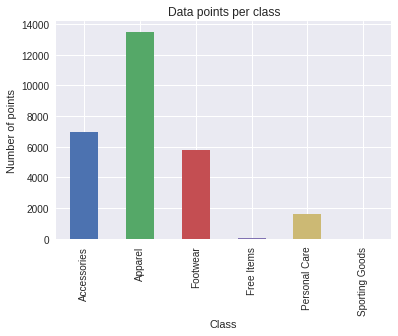

Number of data points in class 1 : 13500 ( 48.41 %)
Number of data points in class 0 : 6944 ( 24.9 %)
Number of data points in class 2 : 5767 ( 20.68 %)
Number of data points in class 4 : 1594 ( 5.716 %)
Number of data points in class 3 : 64 ( 0.229 %)
Number of data points in class 5 : 18 ( 0.065 %)


In [45]:
value_counts = data['masterCategory'].value_counts().sortlevel()

value_counts.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Number of points')
plt.title('Data points per class')
plt.show()

sorted_vc = np.argsort(-value_counts.values)
for i in sorted_vc:
    print('Number of data points in class', i, ':',value_counts.values[i], '(', np.round((value_counts.values[i]/data.shape[0]*100), 3), '%)')

The data is highly imbalaced, with class 1 covering 48% of total datapoints whiles classes 3 and 6 have only 0.229% and 0.065% of points.

### Convering Categorical output into numerical output

In [46]:
le = LabelEncoder()

masterCategoryEncoded = le.fit_transform(data['masterCategory'])
data['masterCategoryEncoded'] = masterCategoryEncoded
data.head()

,id,articleType,productDisplayName,preprocessed_description,masterCategory,masterCategoryEncoded
0,52367,nightdress,red rose women green nightdress,green knee length nightdress round neck sleeve...,Apparel,1
1,52979,sarees,fnf multi coloured sari,multicoloured sari overtones green red self pa...,Apparel,1
2,20431,wallets,baggit women tijori viva brown wallet,worry longer managing money cards coins tote b...,Accessories,0
3,28959,kurtas,biba women ethnic white kurta,white round neck kurta made 100 cotton short p...,Apparel,1
4,53468,bra,amante confidence nudecoloured balconette bra ...,nude coloured black balconette bra lightly pad...,Apparel,1


## Analysis on articleType

In [47]:
#different articles and their number of occurances
data['articleType'].value_counts()

tshirts                      4415
shirts                       2130
casual_shoes                 1779
watches                      1527
sports_shoes                 1286
kurtas                       1147
handbags                     1133
tops                         1016
heels                         842
wallets                       580
sandals                       573
flip_flops                    548
briefs                        543
sunglasses                    540
belts                         519
backpacks                     478
socks                         470
perfume_and_body_mist         406
shorts                        384
formal_shoes                  377
jeans                         350
trousers                      348
flats                         313
sarees                        290
bra                           283
dresses                       263
earrings                      240
deodorant                     216
track_pants                   214
nail_polish   

In [48]:
print('Total unique values in articleType are', len(data['articleType'].unique()))

Total unique values in articleType are 139


### Top articleType for each class

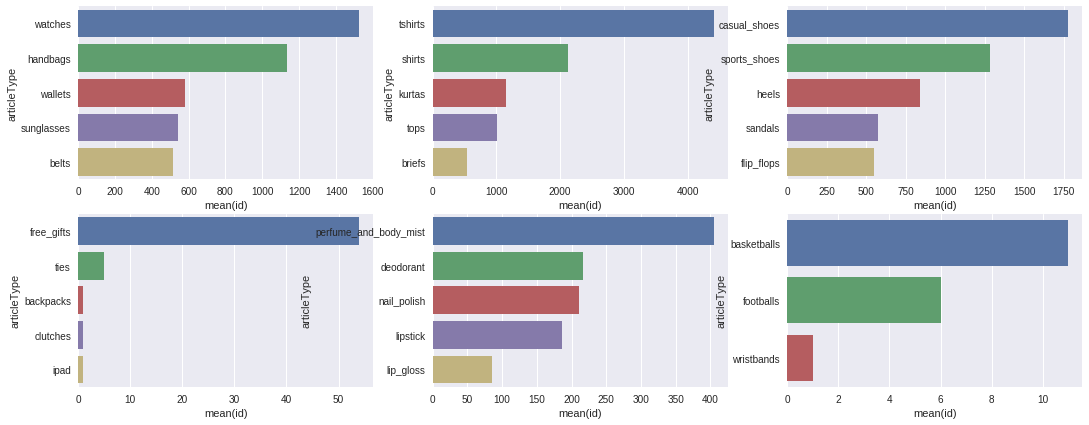

In [49]:
fix, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(18, 7))

for i in range(2):
    for j in range(3):
        feature_counts = data[data['masterCategoryEncoded'] == i*3+j].groupby('articleType')['id'].count().reset_index()         #selecting a master category and grouping by articleType and counting values, 'id' is provided so that count values becomes a column
        sorted_feature_counts = feature_counts.sort_values('id', ascending = False)[0:5]
        sns.barplot(x = 'id', y = 'articleType', data = sorted_feature_counts, ax=axs[i][j])

Top articleType for each class are very different, hence this feature can be very usefull in classification.

## Analysis on displayName

### Top words for each class

In [0]:
#creating a dictionary which will contain a word as key and its frequency as value for a single class

#takes a dataframe which will contain rows of a particular class
def dictionary_for_class(df):
    dictionary = defaultdict(int)
    for index, row in df.iterrows():
        for word in row['productDisplayName'].split():
            dictionary[word] +=1
    return dictionary

In [0]:
dict_list = []                                             #a dictionary which will contain 6 dictionarys for each class

for i in range(0,6):
    df = data[data['masterCategoryEncoded'] == i]
    dict_list.append(dictionary_for_class(df))

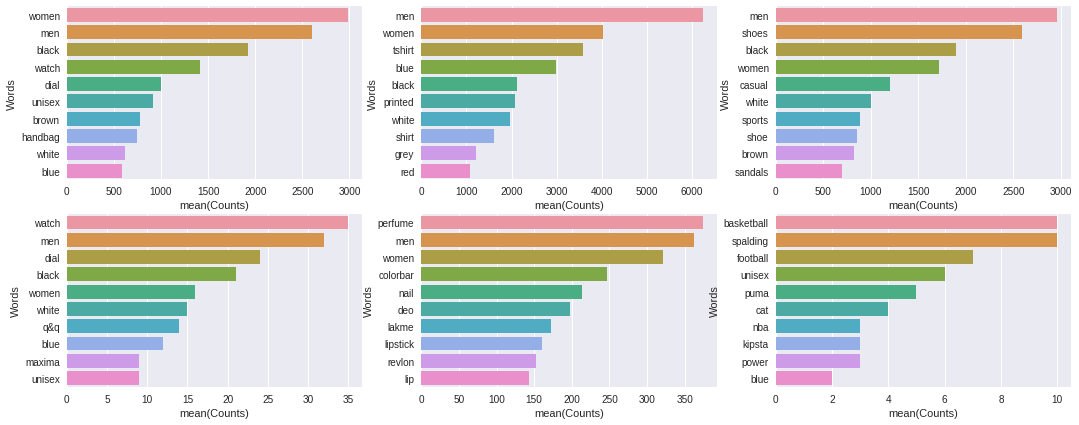

In [52]:
fix, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(18, 7))

for i in range(2):
    for j in range(3):
        temp = pd.DataFrame(list(dict_list[(i*3+j)].items()), columns = ['Words', 'Counts'])
        sorted_words = temp.sort_values('Counts', ascending = False)[:10]
        sns.barplot(x = "Counts", y = "Words", data = sorted_words, ax=axs[i][j])

Top words for each categories have some common words like, men, women, black. white, etc. Hence this feature wont be much usefull in classification

## Analysis on discription

### Top words for each class

In [0]:
#creating a dictionary which will contain a word as key and its frequency as value for a single class

#takes a dataframe which will contain rows of a particular class
def dictionary_for_class(df):
    dictionary = defaultdict(int)
    for index, row in df.iterrows():
        for word in row['preprocessed_description'].split():
            dictionary[word] +=1
    return dictionary

In [0]:
dict_list = []                                             #a dictionary which will contain 6 dictionarys for each class

for i in range(0,6):
    df = data[data['masterCategoryEncoded'] == i]
    dict_list.append(dictionary_for_class(df))

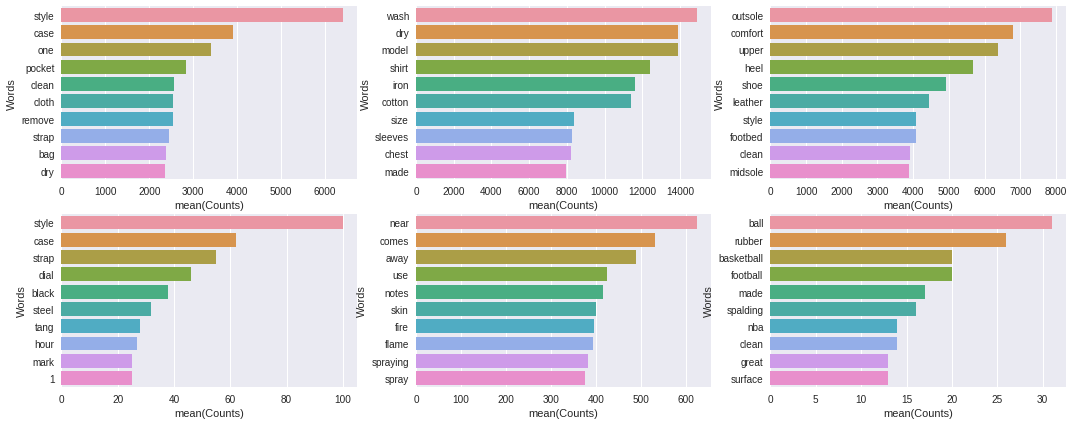

In [55]:
fix, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(18, 7))

for i in range(2):
    for j in range(3):
        temp = pd.DataFrame(list(dict_list[(i*3+j)].items()), columns = ['Words', 'Counts'])
        sorted_words = temp.sort_values('Counts', ascending = False)[:10]
        sns.barplot(x = "Counts", y = "Words", data = sorted_words, ax=axs[i][j])

Top words are each class are very different except for class 0 and 3 i.e Accessories and Free Items. Maybe many of the  Free Items are Accessories.

As top words for each class are different we can easily classify the data points. However there are very few data points for Free Items and Sporting Goods classes, which can be a problem.

# Creating train and test dataset

## Splitting the dataset

In [56]:
#creating input and output parts
X = data.drop(['masterCategory', 'masterCategoryEncoded'], axis = 1)
Y = data['masterCategoryEncoded']

#splitting the data into train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size = 0.2, stratify = Y_train, random_state = 0)

print("Shape of tr data, cv data and test data is :", X_tr.shape, X_cv.shape, X_test.shape)

Shape of tr data, cv data and test data is : (17847, 4) (4462, 4) (5578, 4)


In [57]:
X_tr.head()

,id,articleType,productDisplayName,preprocessed_description
4341,32036,socks,playboy men navy socks,navy blue light blue socks ribbed mouth brandi...
26339,59502,pendant,lucera gold plated pendant with chain,gold toned pendant encrusted stones comes chai...
15957,12852,shirts,ant kids pocket button green shirts,green black white check shirt made 100 cotton ...
8569,5870,casual_shoes,converse unisex heck os black white shoe,dedicated basketball champ chuck taylor chuck ...
12255,34105,shorts,doodle boys check blue shorts,multi hued check shorts two side pockets two p...


### Distribution of class labels for train, cv and test data.

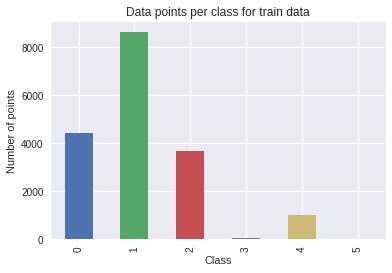

Number of data points in class 1 : 8640 ( 48.411 %)
Number of data points in class 0 : 4444 ( 24.901 %)
Number of data points in class 2 : 3691 ( 20.681 %)
Number of data points in class 4 : 1020 ( 5.715 %)
Number of data points in class 3 : 41 ( 0.23 %)
Number of data points in class 5 : 11 ( 0.062 %)
--------------------------------------------------------------------------------


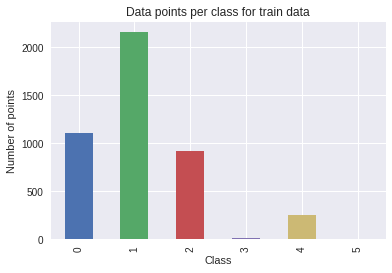

Number of data points in class 1 : 2160 ( 12.103 %)
Number of data points in class 0 : 1111 ( 6.225 %)
Number of data points in class 2 : 923 ( 5.172 %)
Number of data points in class 4 : 255 ( 1.429 %)
Number of data points in class 3 : 10 ( 0.056 %)
Number of data points in class 5 : 3 ( 0.017 %)
--------------------------------------------------------------------------------


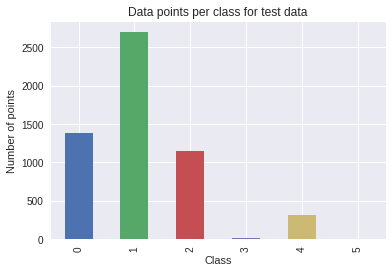

Number of data points in class 1 : 2700 ( 48.404 %)
Number of data points in class 0 : 1389 ( 24.901 %)
Number of data points in class 2 : 1153 ( 20.67 %)
Number of data points in class 4 : 319 ( 5.719 %)
Number of data points in class 3 : 13 ( 0.233 %)
Number of data points in class 5 : 4 ( 0.072 %)


In [58]:
value_counts = Y_tr.value_counts().sortlevel()

value_counts.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Number of points')
plt.title('Data points per class for train data')
plt.show()

sorted_vc = np.argsort(-value_counts.values)
for i in sorted_vc:
    print('Number of data points in class', i, ':',value_counts.values[i], '(', np.round((value_counts.values[i]/X_tr.shape[0]*100), 3), '%)')
    
   
print('-'*80)
value_counts = Y_cv.value_counts().sortlevel()

value_counts.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Number of points')
plt.title('Data points per class for train data')
plt.show()

sorted_vc = np.argsort(-value_counts.values)
for i in sorted_vc:
    print('Number of data points in class', i, ':',value_counts.values[i], '(', np.round((value_counts.values[i]/X_tr.shape[0]*100), 3), '%)')

    
print('-'*80)
value_counts = Y_test.value_counts().sortlevel()

value_counts.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Number of points')
plt.title('Data points per class for test data')
plt.show()

sorted_vc = np.argsort(-value_counts.values)
for i in sorted_vc:
    print('Number of data points in class', i, ':',value_counts.values[i], '(', np.round((value_counts.values[i]/X_test.shape[0]*100), 3), '%)')

## Encoding Features

### One Hot encoding of articleType

In [59]:
vectorizer = CountVectorizer(lowercase = False, binary = True)
articleType_tr = vectorizer.fit_transform(X_tr['articleType'].values)
articleType_cv = vectorizer.transform(X_cv['articleType'].values)
articleType_test = vectorizer.transform(X_test['articleType'].values)

print("Shape of matrix after one hot encoding ",articleType_tr.shape)
print("Shape of matrix after one hot encoding ",articleType_cv.shape)
print("Shape of matrix after one hot encoding ",articleType_test.shape)

Shape of matrix after one hot encoding  (17847, 136)
Shape of matrix after one hot encoding  (4462, 136)
Shape of matrix after one hot encoding  (5578, 136)


### Bag of words encoding of product displayName

In [60]:
vectorizer = CountVectorizer(min_df = 10)
displayName_tr = vectorizer.fit_transform(X_tr['productDisplayName'])
displayName_cv = vectorizer.transform(X_cv['productDisplayName'])
displayName_test = vectorizer.transform(X_test['productDisplayName'])

print("Shape of matrix after bow encoding ",displayName_tr.shape)
print("Shape of matrix after bow encoding ",displayName_cv.shape)
print("Shape of matrix after bow encoding ",displayName_test.shape)

Shape of matrix after bow encoding  (17847, 806)
Shape of matrix after bow encoding  (4462, 806)
Shape of matrix after bow encoding  (5578, 806)


### Bag of words encoding of product description

In [61]:
vectorizer = CountVectorizer(min_df = 10)
description_tr = vectorizer.fit_transform(X_tr['preprocessed_description'])
description_cv = vectorizer.transform(X_cv['preprocessed_description'])
description_test = vectorizer.transform(X_test['preprocessed_description'])

print("Shape of matrix after bow encoding ",description_tr.shape)
print("Shape of matrix after bow encoding ",description_cv.shape)
print("Shape of matrix after bow encoding ",description_test.shape)

Shape of matrix after bow encoding  (17847, 5117)
Shape of matrix after bow encoding  (4462, 5117)
Shape of matrix after bow encoding  (5578, 5117)


### Encoding Image as feature vector using VGG16 model

In [62]:
#https://medium.com/@franky07724_57962/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

model = VGG16(include_top = False, weights = 'imagenet')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


In [63]:
dir_path = './fashion-dataset/images/'
image_tr = []
image_cv = []
image_test = []
#for train set
for index, row in X_tr.iterrows():
    img_path = dir_path + str(row['id']) + '.jpg'

    img = image.load_img(img_path, target_size = (224, 224))         #loads the perticular image
    img_data = image.img_to_array(img)                               #converts image to array, shape = (224, 224, 3)
    img_data = np.expand_dims(img_data, axis = 0)                    #changing the shape of image to 4d, the extra dimension is for batch
    img_data = preprocess_input(img_data)                            #shape = (1, 224, 224, 3)
    
    image_feature = model.predict(img_data)
    image_feature = image_feature.reshape(25088)
    
    image_tr.append(image_feature)

    
#for cv set
for index, row in X_cv.iterrows():
    img_path = dir_path + str(row['id']) + '.jpg'

    img = image.load_img(img_path, target_size = (224, 224))         #loads the perticular image
    img_data = image.img_to_array(img)                               #converts image to array, shape = (224, 224, 3)
    img_data = np.expand_dims(img_data, axis = 0)                    #changing the shape of image to 4d, the extra dimension is for batch
    img_data = preprocess_input(img_data)                            #shape = (1, 224, 224, 3)
    
    image_feature = model.predict(img_data)
    image_feature = image_feature.reshape(25088)
    
    image_cv.append(image_feature)

    
#for test set
for index, row in X_test.iterrows():
    img_path = dir_path + str(row['id']) + '.jpg'
    
    img = image.load_img(img_path, target_size = (224, 224))         #loads the perticular image
    img_data = image.img_to_array(img)                               #converts image to array, shape = (224, 224, 3)
    img_data = np.expand_dims(img_data, axis = 0)                    #changing the shape of image to 4d, the extra dimension is for batch
    img_data = preprocess_input(img_data)                            #shape = (1, 224, 224, 3)
    
    image_feature = model.predict(img_data)
    image_feature = image_feature.reshape(25088)
    
    image_test.append(image_feature) 
    
print("Shape of matrix after image encoding", len(image_tr))
print("Shape of matrix after image encoding", len(image_cv))
print("Shape of matrix after image encoding", len(image_test))

Shape of matrix after image encoding 17847
Shape of matrix after image encoding 4462
Shape of matrix after image encoding 5578


### Stacking the above features

In [64]:
Xtr = hstack((articleType_tr, displayName_tr, description_tr, image_tr)).tocsr()
Xcv = hstack((articleType_cv, displayName_cv, description_cv, image_cv)).tocsr()
Xtest = hstack((articleType_test, displayName_test, description_test, image_test)).tocsr()

print("Shape of train data matrix", Xtr.shape)
print("Shape of cv data matrix", Xcv.shape)
print("Shape of test data matrix", Xtest.shape)

Shape of train data matrix (17847, 31147)
Shape of cv data matrix (4462, 31147)
Shape of test data matrix (5578, 31147)


## TSNE visualization of data points

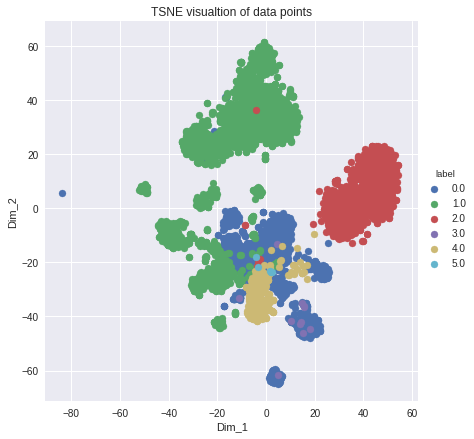

In [0]:
x = Xtr.toarray()[:5000]
y = Y_tr[:5000]
model = TSNE(n_components = 2, perplexity = 50, random_state = 0)
tsne_data = model.fit_transform(x)
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1','Dim_2').add_legend()
plt.title("TSNE visualtion of data points")
plt.show()

The graph shows that data is quite seperable, only at some points there is overlap between the classes

# Machine Learning Modelling

In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A = (((C.T)/(C.sum(axis = 1))).T)
    B = (C/C.sum(axis = 0))

    labels = [0, 1, 2, 3, 4, 5]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize = (15,7))
    sns.heatmap(C, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize = (15,7))
    sns.heatmap(B, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize = (15,7))
    sns.heatmap(A, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## Random Model

Log loss on Test Data using Random Model 2.0878165506159982
-------------------- Confusion matrix --------------------


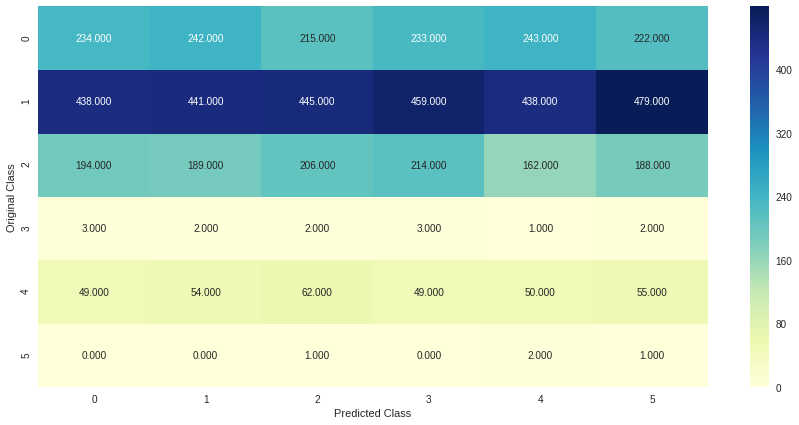

-------------------- Precision matrix (Columm Sum=1) --------------------


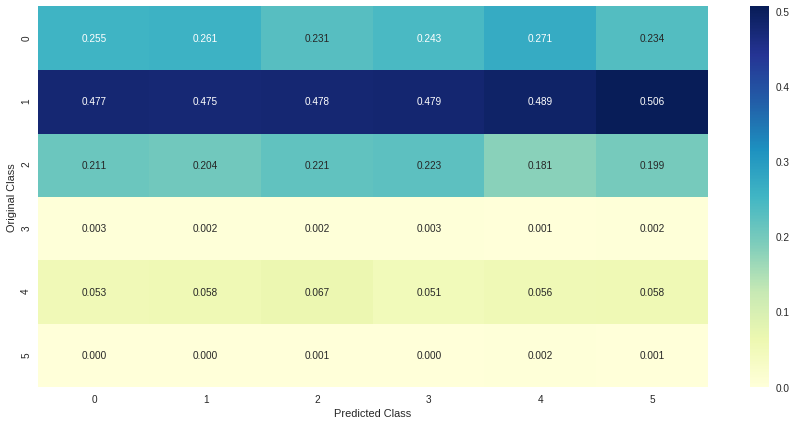

-------------------- Recall matrix (Row sum=1) --------------------


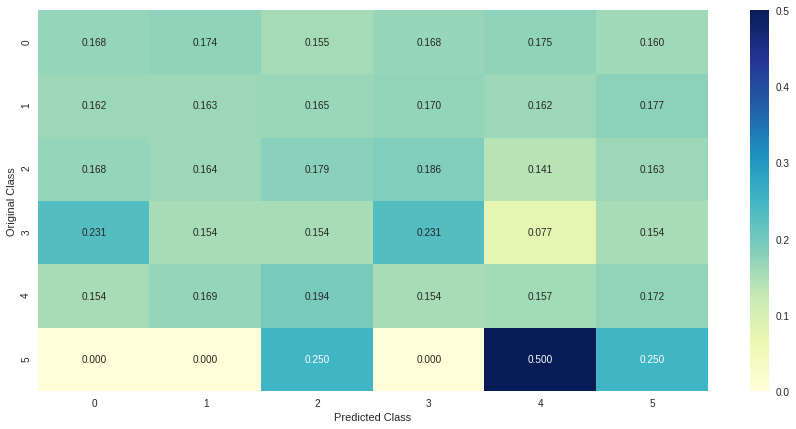

In [0]:
# we need to generate 6 numbers and the sum of numbers should be 1
# one solution is to genarate 6 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = Xtest.shape[0]

#Test set
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len, 6))
for i in range(test_data_len):
    rand_probs = np.random.rand(1, 6)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model", log_loss(Y_test, test_predicted_y, eps = 1e-15))

predicted_y = np.argmax(test_predicted_y, axis = 1)
plot_confusion_matrix(Y_test, predicted_y)

## Logistic Regression model

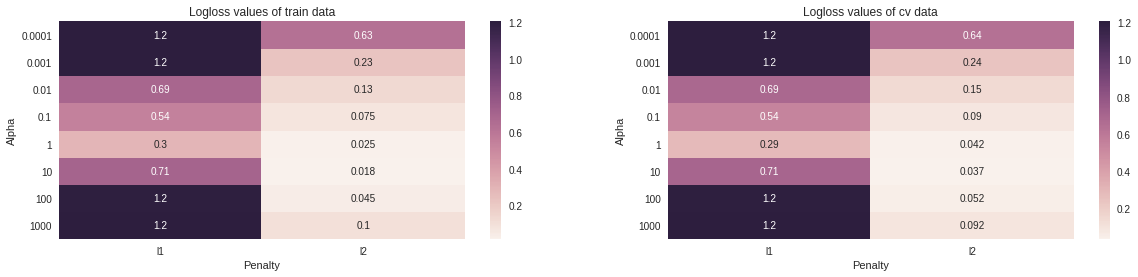

In [0]:
alpha = [10**i for i in range(-4, 4)]
penalty = ['l1', 'l2']

logloss_tr_array = []
logloss_cv_array = []
for i in alpha:
    for j in penalty:
        model = SGDClassifier(alpha = i, penalty = j, loss = 'log')
        sig_clf = CalibratedClassifierCV(model, method = "sigmoid")
        sig_clf.fit(Xtr, Y_tr)    
        pred_tr = sig_clf.predict_proba(Xtr)
        pred_cv = sig_clf.predict_proba(Xcv)
        logloss_tr_array.append(log_loss(Y_tr, pred_tr))
        logloss_cv_array.append(log_loss(Y_cv, pred_cv))
        
        
#Heatmaps for logloss of train and test data
plt.figure(figsize = (20,4))
plt.subplot(1, 2, 1)
logloss_tr_array = np.array(logloss_tr_array)
logloss_tr_array = logloss_tr_array.reshape(len(alpha),len(penalty))
sns.heatmap(logloss_tr_array, annot = True, xticklabels = penalty, yticklabels = alpha)
plt.xlabel('Penalty')
plt.ylabel('Alpha')
plt.title('Logloss values of train data')

plt.subplot(1, 2, 2)
logloss_cv_array = np.array(logloss_cv_array)
logloss_cv_array = logloss_cv_array.reshape(len(alpha),len(penalty))
sns.heatmap(logloss_cv_array, annot = True, xticklabels = penalty, yticklabels = alpha)
plt.xlabel('Penalty')
plt.ylabel('Alpha')
plt.title('Logloss values of cv data')
plt.show()

Values of best parameters are alpha : 10 and penalty : l2
Training on best parameters...
For best parameters train logloss is 0.01830914628166722 and test logloss is 0.03998018134724457
-------------------- Confusion matrix --------------------


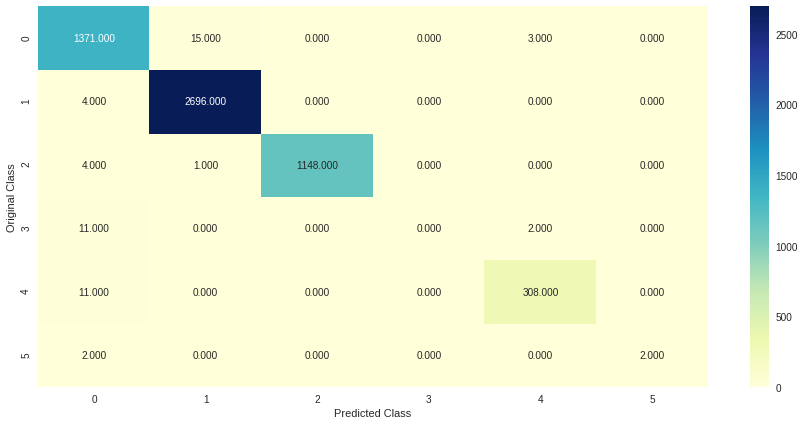

-------------------- Precision matrix (Columm Sum=1) --------------------


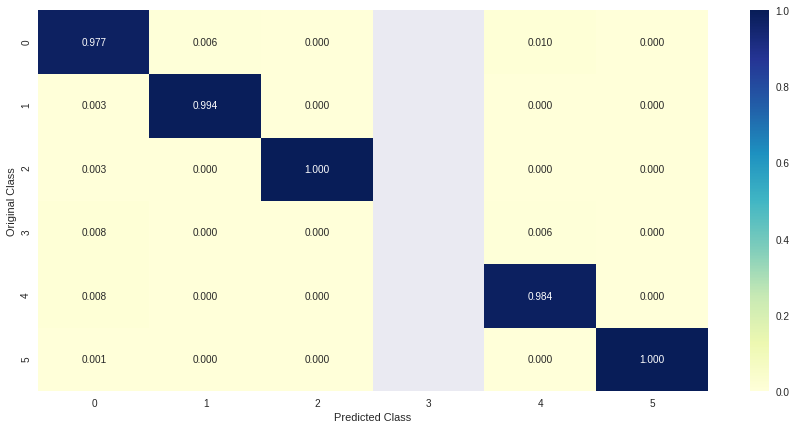

-------------------- Recall matrix (Row sum=1) --------------------


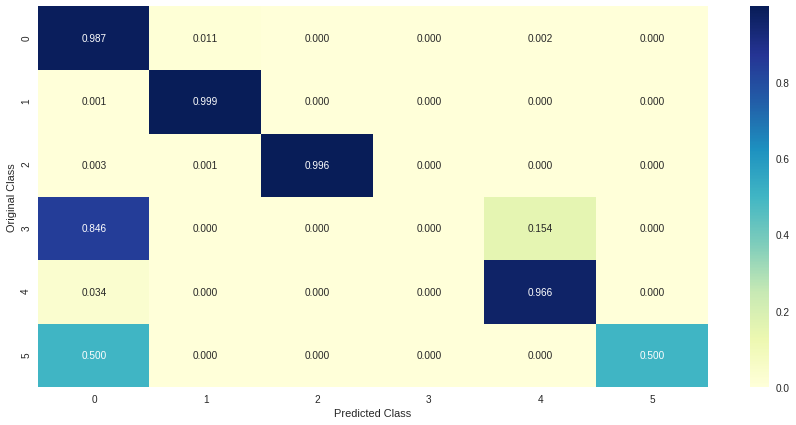

In [71]:
print("Values of best parameters are alpha : 10 and penalty : l2")
print("Training on best parameters...")

model = SGDClassifier(alpha = 10, penalty = 'l2', loss = 'log')
sig_clf = CalibratedClassifierCV(model, method = "sigmoid")
sig_clf.fit(Xtr, Y_tr)    

pred_tr = sig_clf.predict_proba(Xtr)
pred_test = sig_clf.predict_proba(Xtest)

logloss_tr_lr = log_loss(Y_tr, pred_tr)
logloss_test_lr = log_loss(Y_test, pred_test)
print("For best parameters train logloss is", logloss_tr_lr, "and test logloss is", logloss_test_lr)

plot_confusion_matrix(Y_test, sig_clf.predict(Xtest))

As said before that Free Items(Class 3) are similar to Accesorries(Class0), we can see in the confusion matrix and recall matrix of test set, that the points belonging to class 3 are getting predicted as class 0 class 2. 

## Random Forest Model

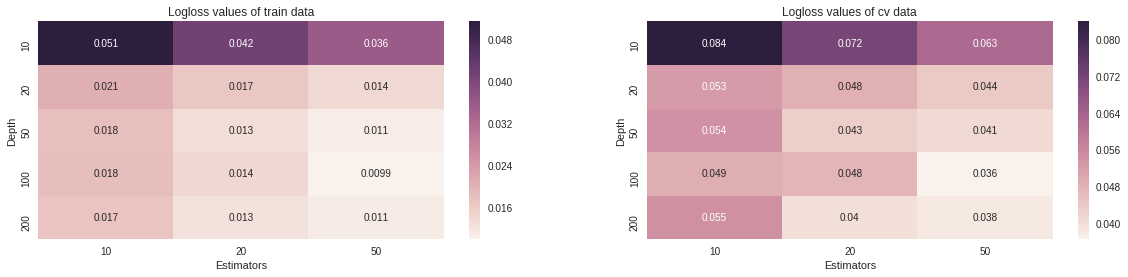

In [0]:
max_depth = [10, 20, 50, 100, 200]
n_estimators = [10, 20, 50]

logloss_tr_array = []
logloss_cv_array = []
for i in max_depth:
    for j in n_estimators:
        model = RandomForestClassifier(max_depth = i, n_estimators = j)
        sig_clf = CalibratedClassifierCV(model, method = "sigmoid")
        sig_clf.fit(Xtr, Y_tr)    
        pred_tr = sig_clf.predict_proba(Xtr)
        pred_cv = sig_clf.predict_proba(Xcv)
        logloss_tr_array.append(log_loss(Y_tr, pred_tr))
        logloss_cv_array.append(log_loss(Y_cv, pred_cv))
        
        
#Heatmaps for logloss of train and test data
plt.figure(figsize = (20,4))
plt.subplot(1, 2, 1)
logloss_tr_array = np.array(logloss_tr_array)
logloss_tr_array = logloss_tr_array.reshape(len(max_depth),len(n_estimators))
sns.heatmap(logloss_tr_array, annot = True, xticklabels = n_estimators, yticklabels = max_depth)
plt.xlabel('Estimators')
plt.ylabel('Depth')
plt.title('Logloss values of train data')

plt.subplot(1, 2, 2)
logloss_cv_array = np.array(logloss_cv_array)
logloss_cv_array = logloss_cv_array.reshape(len(max_depth),len(n_estimators))
sns.heatmap(logloss_cv_array, annot = True, xticklabels = n_estimators, yticklabels = max_depth)
plt.xlabel('Estimators')
plt.ylabel('Depth')
plt.title('Logloss values of cv data')
plt.show()

Values of best parameters are max_depth : 100 and n_estimators : 50
Training on best parameters...
For best parameters train logloss is 0.010658678921453184 and test logloss is 0.03717527191379461
-------------------- Confusion matrix --------------------


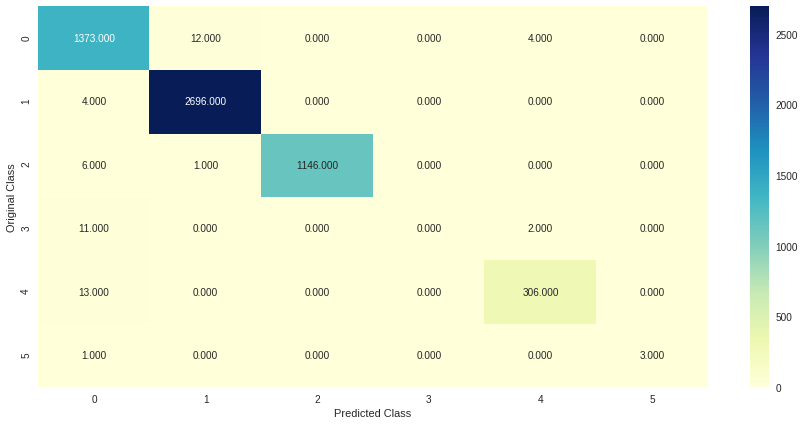

-------------------- Precision matrix (Columm Sum=1) --------------------


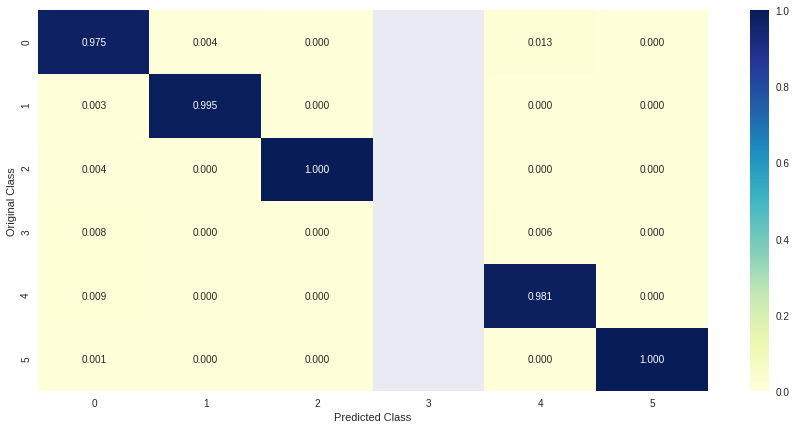

-------------------- Recall matrix (Row sum=1) --------------------


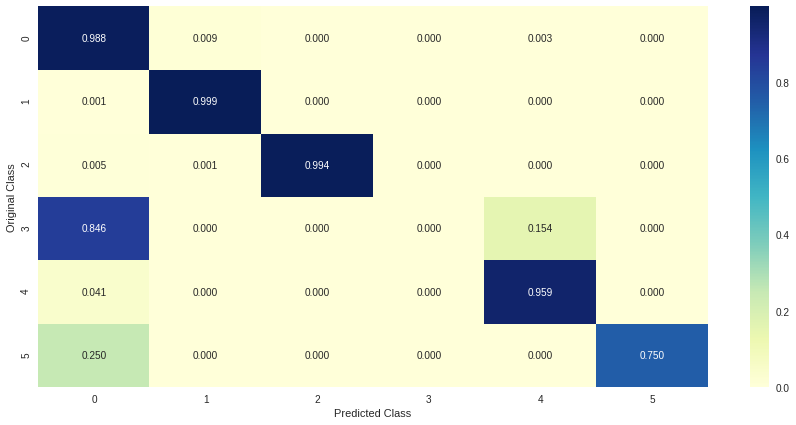

In [70]:
print("Values of best parameters are max_depth : 100 and n_estimators : 50")
print("Training on best parameters...")

model = RandomForestClassifier(max_depth = 50, n_estimators = 50)
sig_clf = CalibratedClassifierCV(model, method = "sigmoid")
sig_clf.fit(Xtr, Y_tr)    

pred_tr = sig_clf.predict_proba(Xtr)
pred_test = sig_clf.predict_proba(Xtest)

logloss_tr_rf = log_loss(Y_tr, pred_tr)
logloss_test_rf = log_loss(Y_test, pred_test)
print("For best parameters train logloss is", logloss_tr_rf, "and test logloss is", logloss_test_rf)

plot_confusion_matrix(Y_test, sig_clf.predict(Xtest))

## XGBoost Model

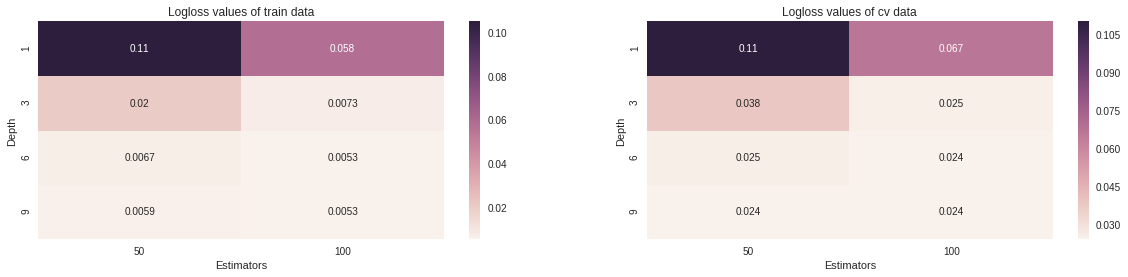

In [65]:
max_depth = [1, 3, 6, 9]
n_estimators = [50, 100]

logloss_tr_array = []
logloss_cv_array = []
for i in max_depth:
    for j in n_estimators:
        model = XGBClassifier(max_depth = i, n_estimators = j)
        sig_clf = CalibratedClassifierCV(model, method = "sigmoid")
        sig_clf.fit(Xtr, Y_tr)    
        pred_tr = sig_clf.predict_proba(Xtr)
        pred_cv = sig_clf.predict_proba(Xcv)
        logloss_tr_array.append(log_loss(Y_tr, pred_tr))
        logloss_cv_array.append(log_loss(Y_cv, pred_cv))

#Heatmaps for logloss of train and test data
plt.figure(figsize = (20,4))
plt.subplot(1, 2, 1)
logloss_tr_array = np.array(logloss_tr_array)
logloss_tr_array = logloss_tr_array.reshape(len(max_depth),len(n_estimators))
sns.heatmap(logloss_tr_array, annot = True, xticklabels = n_estimators, yticklabels = max_depth)
plt.xlabel('Estimators')
plt.ylabel('Depth')
plt.title('Logloss values of train data')

plt.subplot(1, 2, 2)
logloss_cv_array = np.array(logloss_cv_array)
logloss_cv_array = logloss_cv_array.reshape(len(max_depth),len(n_estimators))
sns.heatmap(logloss_cv_array, annot = True, xticklabels = n_estimators, yticklabels = max_depth)
plt.xlabel('Estimators')
plt.ylabel('Depth')
plt.title('Logloss values of cv data')
plt.show()

Values of best parameters are max_depth : 3 and n_estimators : 100
Training on best parameters...
For best parameters train logloss is 0.007330568828890052 and test logloss is 0.022584469401845105
-------------------- Confusion matrix --------------------


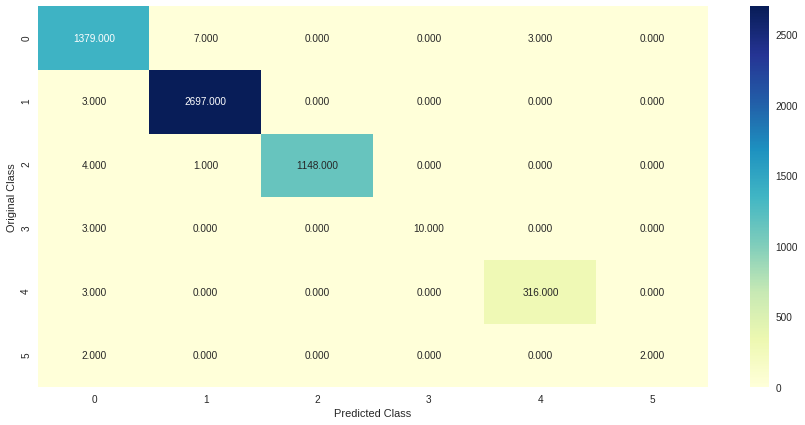

-------------------- Precision matrix (Columm Sum=1) --------------------


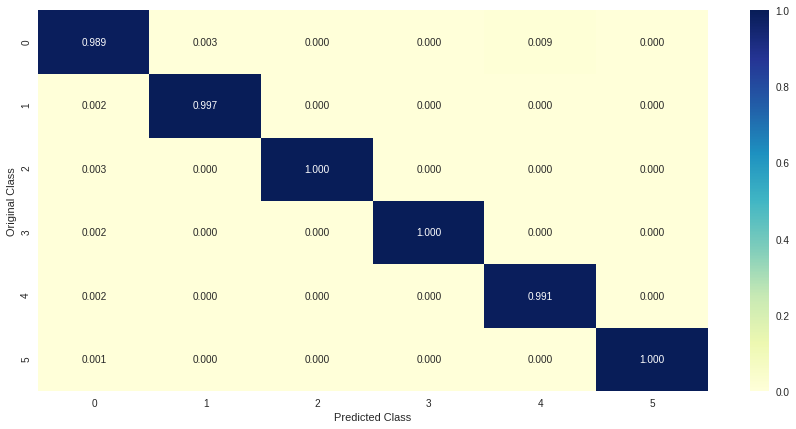

-------------------- Recall matrix (Row sum=1) --------------------


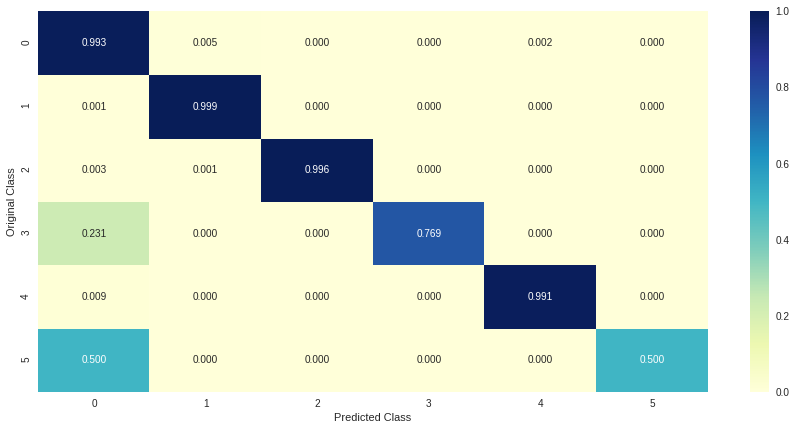

In [69]:
print("Values of best parameters are max_depth : 3 and n_estimators : 100")
print("Training on best parameters...")

model = XGBClassifier(max_depth = 3, n_estimators = 100)
sig_clf = CalibratedClassifierCV(model, method = "sigmoid")
sig_clf.fit(Xtr, Y_tr)    

pred_tr = sig_clf.predict_proba(Xtr)
pred_test = sig_clf.predict_proba(Xtest)

logloss_tr_xgb = log_loss(Y_tr, pred_tr)
logloss_test_xgb = log_loss(Y_test, pred_test)
print("For best parameters train logloss is", logloss_tr_xgb, "and test logloss is", logloss_test_xgb)

plot_confusion_matrix(Y_test, sig_clf.predict(Xtest))

# Step by Step Procedure

1. Reading json files and extracting product data from json files
2. Preprocessing the extracted data, such as removal of html tags, removal of stopwords, etc from description and display name of products
3. Analysis on different features describing how much different values they can take for each class
4. Featuring data using one hot encoding and bag of words encoding
5. Modelling data using Logistic Regression, Random Forest and XGBoost

# Model Comparison

In [72]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ["Model", "Train Logloss", "Test Logloss"]
t.add_row(["Logistic Regression", logloss_tr_lr, logloss_test_lr])
t.add_row(["Random Forest", logloss_tr_rf, logloss_test_rf])
t.add_row(["XGBoost", logloss_tr_xgb, logloss_test_xgb])
print(t)

+---------------------+----------------------+----------------------+
|        Model        |    Train Logloss     |     Test Logloss     |
+---------------------+----------------------+----------------------+
| Logistic Regression | 0.01830914628166722  | 0.03998018134724457  |
|    Random Forest    | 0.010658678921453184 | 0.03717527191379461  |
|       XGBoost       | 0.007330568828890052 | 0.022584469401845105 |
+---------------------+----------------------+----------------------+
